In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
%matplotlib inline
import warnings
from matplotlib.ticker import FormatStrFormatter
warnings.filterwarnings('ignore')
from matplotlib import gridspec

In [2]:
def to_seconds(timestamp):
    ts = timestamp.split(':')
    try: return float(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))
    except: return float(0)

def mdtest(fname):
    with open(fname) as f:
        start = end = ""
        data = json.load(f)
        for line in data['stdout_lines']:
            if "started" in line: start = line.split()[4]
            if "finished" in line: end = line.split()[4]
        result = to_seconds(end) - to_seconds(start)
        if result < 0: return 0
        return result
    
def parse(expdir):
    df = pd.DataFrame(columns=['job', 'nfile', 'rtime'])
    for s in ["stream", "nostream"]:
        with open(expdir + s + '.txt') as f:
            d = pd.read_csv(f, names=['job', 'time', 'delta'])
            d['rtime'] = d['delta'].apply(to_seconds)
            d['nfile'] = np.full(len(d), '100000')
            del d['time'], d['delta']
            d['job'] = d['job'] + '-' + s + '-run0'
            df = df.append(d, ignore_index=True)
        # parse the RPCs execution times
        df.loc[len(df)] = ["RPCs-" + s + '-run0'] + [float('100000')] + [mdtest(expdir + 'rpcs-' + s + '.txt')]
    return df
    
def transfertime():
    with open("../results-all/dummy100k.txt") as f:
        for line in f:
            y = line
    return float(y)

def relabel(df):
    for j in ['RPCs', 'create', 'save', 'persist', 'v.apply', 'apply']:
        for s in ["stream", "nostream"]:
            dfs = [j + '-' + s + '-run0']
            df[j + '-' + s] = df[dfs].mean(axis=1)
    return df

# calculate the phase execution times
def calculate(df):
    df['transfertime'] =      [transfertime()] 
    df['RPCs'] =              df['RPCs-nostream']
    df['stream'] =            df['RPCs-stream'] - df['RPCs-nostream']
    df['create'] =            df['create-nostream']
    df['local persist'] =     df['save-nostream'] - df['create']
    df['global persist'] =    df['persist-nostream'] - df['create']
    df['volatile apply'] =    df['v.apply-nostream'] - df['create'] + df['transfertime']
    df['nonvolatile apply'] = df['apply-nostream'] - df['create']
    d = df[['stream', 'local persist', 'global persist', 'RPCs', 'nonvolatile apply', 'volatile apply']]
    d = d[:].div(df['create'], axis=0)    
    return d

# persist is which bars to draw on
def draw_hatches(ax, slow, persist):
    i = 0
    for bar, hatch in zip(ax.patches, ''.join(h*len(slow) for h in 'xxx   ')):
        if i in persist:
            bar.set_hatch(hatch)
        i += 1

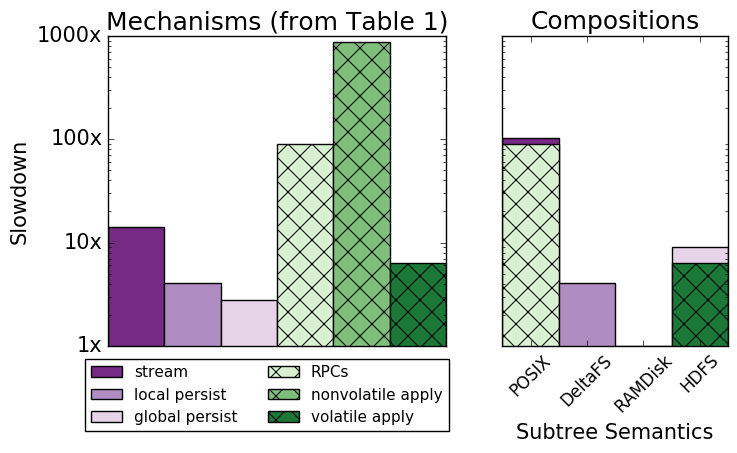

In [3]:
font = {'size'   : 15}; matplotlib.rc('font', **font)
fig = plt.figure(figsize=(8, 4)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[6, 4]) 
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

# parse job phases
df = parse('../results-all/results-run0/100000/summary-')
df = df.pivot(index='nfile', values='rtime', columns='job')
df = relabel(df)
df = calculate(df)

# plot slowdowns, organized as label, value, color
slow = [('stream', float(df['stream']), '#762a83'), 
        ('local persist', float(df['local persist']), '#af8dc3'),
        ('global persist', float(df['global persist']), '#e7d4e8'),
        ('RPCs', float(df['RPCs']), '#d9f0d3'),
        ('nonvolatile apply',float(df['nonvolatile apply']), '#7fbf7b'),
        ('volatile apply',float(df['volatile apply']), '#1b7837')]
i = 1
for label, value, color in slow:
    ax.bar([i], value, label=label, color=color, width=1)    
    i += 1

# plot applications, organized as label, value, color
apps = [('POSIX', [(float(df['RPCs'] + df['stream']), '#762a83'), (float(df['RPCs']), '#d9f0d3')]),
        ('DeltaFS', [(float(df['local persist']), '#af8dc3')]),
        ('RAMDisk', [(1, '#af8dc3')]),
        ('HDFS', [(float(df['volatile apply'] + df['global persist']), '#e7d4e8'), (float(df['volatile apply']),  '#1b7837')])]
i = 1; labels = []; x = []
for label, values in apps:
    for value, color in values:
        ax2.bar([i], value, color=color, width=1) 
    labels.append(label); x.append(i+0.5)    
    i += 1

# format!
for axis in [ax, ax2]:
    axis.set_yscale('log')
    axis.set_ylim([1,10**3])
    axis.set_yticks([1, 10**1, 10**2, 10**3])
    axis.yaxis.set_major_formatter(FormatStrFormatter('%.0fx'))
ax.set_title("Mechanisms (from Table 1)")
ax.set_ylabel("Slowdown")
ax.set_xticks([])
draw_hatches(ax, slow, [3, 4, 5])
ax2.set_title("Compositions")
ax2.set_yticks([])
ax2.set_xticks(x)
ax2.set_xticklabels(labels, rotation=45, fontsize=12)
ax2.set_xlabel("Subtree Semantics", fontsize=15)
draw_hatches(ax2, slow, [1, 5])
ax.legend(fontsize=11, loc='lower left', ncol=2, bbox_to_anchor=(-0.09, -0.3))
fig.savefig('../../../paper/graphs/composable-mechanisms.png', bbox_inches='tight', dpi=400)